## structure
- get page
    - get link
        - get article
            - get content
            - get image
            - OCR

## data format
- type wrong | partial wrong | correct
- title
- content
- category
- time
- report
- link


## collect

### connect drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### update teseract v5 ppa

In [ ]:
# !rm /opt/conda/lib/libcurl.so.4
# !ln -s /usr/lib/x86_64-linux-gnu/libcurl.so.4.8.0 /opt/conda/lib/libcurl.so.4
!add-apt-repository ppa:alex-p/tesseract-ocr5 -y
!apt update
!apt install -y tesseract-ocr
!apt install tesseract-ocr-eng
# If you want all languages -- please note this will take time to download. You could also point to the already install tessdata in 4.00 as well.
# !apt install tesseract-ocr-all -y
# !tesseract --version

Repository: 'deb https://ppa.launchpadcontent.net/alex-p/tesseract-ocr5/ubuntu/ jammy main'
Description:
 The Tesseract OCR engine was one of the top 3 engines in the 1995
 UNLV Accuracy test. Between 1995 and 2006 it had little work done on
 it, but since then it has been improved extensively by Google and is
 probably one of the most accurate open source OCR engines
 available. It can read a wide variety of image formats and convert
 them to text in over 40 languages. This package includes the command
 line tool.
More info: https://launchpad.net/~alex-p/+archive/ubuntu/tesseract-ocr5
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/alex-p-ubuntu-tesseract-ocr5-jammy.list
Adding deb entry to /etc/apt/sources.list.d/alex-p-ubuntu-tesseract-ocr5-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/alex-p-ubuntu-tesseract-ocr5-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/alex-p-ubuntu-tesseract-ocr5-jammy.list
Adding key to /etc/

### install teseract-ocr v5

In [ ]:
!sudo apt install tesseract-ocr-chi-tra
!sudo apt install tesseract-ocr-chi-sim
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-chi-tra is already the newest version (1:5.0.0~git39-6572757-2ppa1~jammy1).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-chi-sim is already the newest version (1:5.0.0~git39-6572757-2ppa1~jammy1).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


In [ ]:
!tesseract --version | cat
!tesseract --list-langs | cat

tesseract 5.3.4
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found OpenMP 201511
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8
 Found libcurl/7.81.0 OpenSSL/3.0.2 zlib/1.2.11 brotli/1.0.9 zstd/1.4.8 libidn2/2.3.2 libpsl/0.21.0 (+libidn2/2.3.2) libssh/0.9.6/openssl/zlib nghttp2/1.43.0 librtmp/2.3 OpenLDAP/2.5.16
List of available languages in "/usr/share/tesseract-ocr/5/tessdata/" (4):
chi_sim
chi_tra
eng
osd


### import

In [ ]:
import pytesseract
import os,re,random
import pandas as pd
try:
    from PIL import Image
except ImportError:
    import Image
from bs4 import BeautifulSoup
import requests
from requests.utils import requote_uri

### get proxy list

In [ ]:
# res = requests.get('https://free-proxy-list.net/')
# m = re.findall('\d+\.\d+\.\d+\.\d+:\d+', res.text)
# validips = []
# for ip in m:
#     try:
#         res = requests.get('https://api.ipify.org?format=json',proxies = {'http':ip, 'https':ip}, timeout = 5)
#         validips.append({'ip':ip})
#         print(res.json())
#     except:
#         pass
#         # print('FAIL', ip )

{'ip': '8.219.64.236'}
{'ip': '35.247.44.173'}
{'ip': '117.250.3.58'}
{'ip': '158.178.231.110'}
{'ip': '129.154.225.163'}
{'ip': '8.222.152.158'}
{'ip': '45.178.55.2'}
{'ip': '140.238.245.116'}
{'ip': '170.64.222.81'}


In [ ]:
!pip install swiftshadow
from swiftshadow import QuickProxy

In [ ]:
# validips

[{'ip': '8.219.97.248:80'},
 {'ip': '35.185.196.38:3128'},
 {'ip': '117.250.3.58:8080'},
 {'ip': '213.35.124.163:8085'},
 {'ip': '129.154.225.163:8100'},
 {'ip': '8.222.152.158:55555'},
 {'ip': '181.209.110.190:999'},
 {'ip': '140.238.245.116:8100'},
 {'ip': '170.64.222.81:8000'}]

### get website with UA

In [ ]:
def get_html(url):
    # headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36"}
    headers = [
        'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:41.0) Gecko/20100101 Firefox/41.0',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.71 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11) AppleWebKit/601.1.56 (KHTML, like Gecko) Version/9.0 Safari/601.1.56',
        'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_1) AppleWebKit/601.2.7 (KHTML, like Gecko) Version/9.0.1 Safari/601.2.7',
        'Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko',
        'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:41.0) Gecko/20100101 Firefox/41.0',
        'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:41.0) Gecko/20100101 Firefox/41.0',
        'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:41.0) Gecko/20100101 Firefox/41.0',
        'Mozilla/5.0 (Windows NT 6.3; WOW64; rv:41.0) Gecko/20100101 Firefox/41.0',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:41.0) Gecko/20100101 Firefox/41.0',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.71 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2490.80 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/45.0.2454.101 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
        'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:51.0) Gecko/20100101 Firefox/51.0',
    ]
    requests.adapters.DEFAULT_RETRIES = 5
    s = requests.session()
    s.keep_alive = False
    rd = random.randrange(0, len(headers))
    # print(f"user agent {rd}")
    # rd = 0
    headers = {'User-Agent': headers[rd]}
    # proxies = {
    #     'http': random.choice(validips)['ip'],
    #     'https': random.choice(validips)['ip'],
    # }
    proxies = QuickProxy()
    url = requote_uri(url)
    res = s.get(url,headers=headers,proxies=proxies)
    return res


### get all linlks

In [ ]:
def get_pages():
    url = f"{site_url}/articles/report?page="
    done = False
    i = 0
    links = []
    while not done:
        res = get_html(f"{url}{i}")
        res.encoding = 'utf-8'
        if res.status_code != 200:
            done = True
        else:
            print(i,len(links))
            tmp,done =  get_links(res.text)
            links.extend(tmp)
        i += 1
    return links

def get_links(html_doc):
    soup = BeautifulSoup(html_doc, 'html.parser')
    pattern = re.compile(r'^/articles/\d+')
    page = soup.select(".moscone-flipped-content")
    # print(len(page),end=" ")
    links = page[0].find_all("a",href=pattern)
    links = [i.get('href') for i in links]
    links = list(set(links))
    # print(len(links))
    # print(links)
    if len(links) == 0:
        return [],True
    else:
        return links,False

### get images

In [ ]:
def get_image(soup,article_id,path):
    page = soup.select(".content-inner")[0]
    imgs = page.find_all('img')
    # print(imgs)
    src = [i['src'] for i in imgs]
    # print(src)
    idx = 0
    images = []
    img_links = []
    path = os.path.join(path, "images")
    for i in src:
        link = f"{site_url}{i}"
        try:
            res = get_html(link)
        except Exception as e:
            print(link)
            print(e)
            continue

        file_name = f"{article_id}_{idx}{os.path.splitext(i)[1]}"
        file_path = os.path.join(path, file_name)
        images.append(file_path)
        img_links.append(link)
        # print(i,idx,res.status_code,link)
        if res.status_code == 200:
            with open(file_path, 'wb') as f:
                f.write(res.content)
                # print(f"image {idx} saved")
        idx += 1
    return images,img_links

### ocr

In [ ]:
def ocr(image_path):
    text = ""
    try:
        image = Image.open(image_path)
        text = pytesseract.image_to_string(image, lang='chi_tra')
    except Exception as e:
        print("ocr error")
        print(e)
    # print(text)
    return text

### get article

In [ ]:
def get_article(url_id,path):
    url = f"{site_url}{url_id}"
    match_map = re.search(r'articles/',url_id)
    article_id = url_id[match_map.end():]
    is_article = True
    article = {}

    article["link"] = url
    article["article_id"] = article_id

    res = get_html(url)
    res.encoding = 'utf-8'
    html_doc = res.text
    soup = BeautifulSoup(html_doc, 'html.parser')
    # print(res.text)

    title = soup.select(".entity-list-title")[0].text
    reply = soup.select(".node-preface")[0].text
    header = soup.select(".content-inner")[0].select(".node-header")[0]
    time = header.select(".submitted")[0].text
    tags = header.select(".node-tags")[0].find_all("a")
    tags = [i.text for i in tags]
    rumor_type = tags[1]
    category = tags[2]
    imgs,img_links = get_image(soup,article_id,path)
    # print("img error",e)

    if title.find("影片") != -1 or title.find("圖片") != -1 or title.find("照片") != -1:
        is_article = False
        return is_article,article
    idx = 0
    for i in range(len(imgs)):
        tmp = ocr(imgs[i])
        if tmp:
            article[f"ocr_{idx}"] = tmp
            article[f"img_{idx}"] = img_links[i]
            idx += 1
    article["rumor_type"] = rumor_type
    article["category"] = category
    article["time"] = time
    article["title"] = title
    article["reply"] = reply
    return is_article,article

### main

In [ ]:
site_url = 'https://tfc-taiwan.org.tw'
path = "/content/drive/MyDrive/ML/project/graduation/專題資料/"
pages = get_pages()
print(len(pages))

user agent 7
0 0
user agent 12
1 10
user agent 16
2 20
user agent 15
3 30
user agent 14
4 40
user agent 21
5 50
user agent 15
6 60
user agent 17
7 70
user agent 8
8 80
user agent 20
9 90
user agent 5
10 100
user agent 18
11 110
user agent 12
12 120
user agent 14
13 130
user agent 11
14 140
user agent 8
15 150
user agent 21
16 160
user agent 18
17 170
user agent 18
18 180
user agent 11
19 190
user agent 15
20 200
user agent 21
21 210
user agent 8
22 220
user agent 15
23 230
user agent 20
24 240
user agent 0
25 250
user agent 13
26 260
user agent 11
27 270
user agent 6
28 280
user agent 1
29 290
user agent 0
30 300
user agent 16
31 310
user agent 7
32 320
user agent 10
33 330
user agent 10
34 340
user agent 10
35 350
user agent 18
36 360
user agent 12
37 370
user agent 11
38 380
user agent 22
39 390
user agent 0
40 400
user agent 17
41 410
user agent 15
42 420
user agent 13
43 430
user agent 10
44 440
user agent 13
45 450
user agent 8
46 460
user agent 0
47 470
user agent 18
48 480
user 

In [ ]:
site_url# = 'https://tfc-taiwan.org.tw'

'https://tfc-taiwan.org.tw'

  0%|          | 3/2330 [00:31<7:01:46, 10.88s/it]

ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9063_0'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9063_2'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9063_4'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9063_6'


  0%|          | 4/2330 [00:56<10:48:16, 16.72s/it]

https://tfc-taiwan.org.tw
Failed to parse: https://tfc-taiwan.org.tw

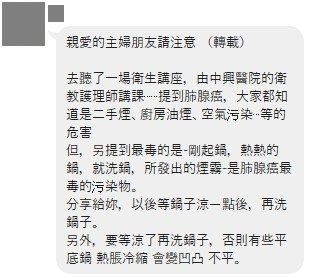
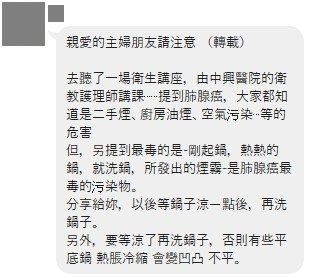

  0%|          | 5/2330 [01:05<8:52:20, 13.74s/it] 

https://tfc-taiwan.org.tw
Failed to parse: https://tfc-taiwan.org.tw
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9068_0'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9068_1'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9073_0'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9073_3'

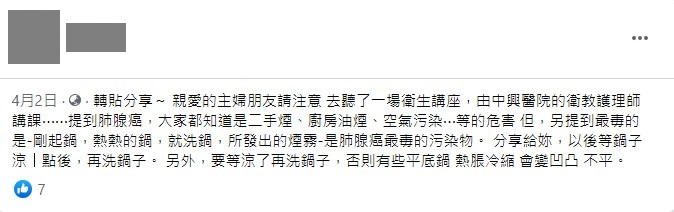
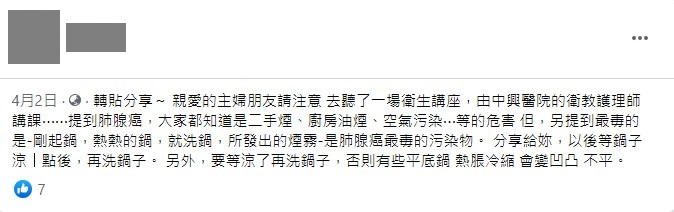

  0%|          | 6/2330 [01:25<10:22:57, 16.08s/it]

ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9076_0'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9076_2'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9076_5'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9076_6'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9076_8'


  0%|          | 7/2330 [01:47<11:36:47, 18.00s/it]

ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9072_0'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9072_2.png'


  0%|          | 8/2330 [01:58<10:01:06, 15.53s/it]

ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9072_4'
https://tfc-taiwan.org.tw
Failed to parse: https://tfc-taiwan.org.tw
https://tfc-taiwan.org.tw
Failed to parse: https://tfc-taiwan.org.tw

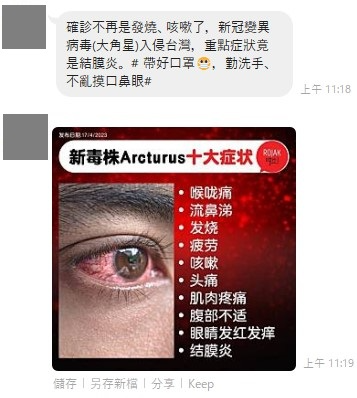
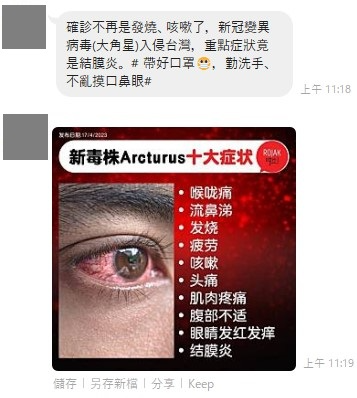
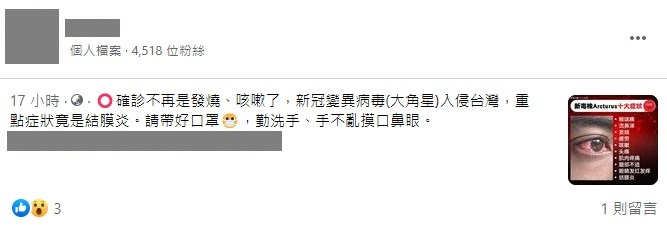
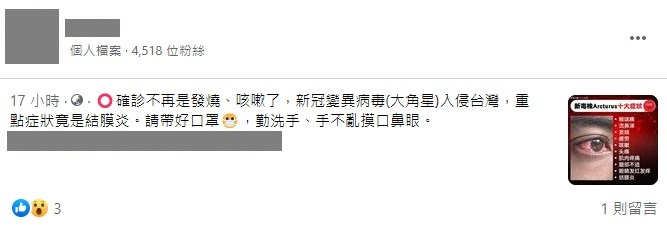

  0%|          | 9/2330 [02:04<8:09:22, 12.65s/it] 

ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9075_0'
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/9075_1'


  0%|          | 10/2330 [02:11<7:01:00, 10.89s/it]

In [ ]:
from tqdm import tqdm
data = []
not_article = []
start = 628
j = start
for i in tqdm(range(start,len(pages))):
    # print(pages[i],j)
    try:
        is_article,article = get_article(pages[i],path)
        if is_article:
            data.append(article)
        else:
            not_article.append(article)
        j += 1
    except Exception as e:
        print(pages[i],j)
        print("I DON'T FREAKING CARE WTFROG ERROR!")
        print(e)
print(len(data),len(not_article))

### test

In [ ]:
len(pages)

In [ ]:
path = "/content/drive/MyDrive/ML/project/graduation/專題資料/"
# # test
# site_url = 'https://tfc-taiwan.org.tw'
# path = "/content/drive/MyDrive/ML/project/graduation/"
x = "/articles/10396"
t,article = get_article(x,path)
print(article.keys())


user agent 8
user agent 5
user agent 4
user agent 10
ocr error
[Errno 2] No such file or directory: '/content/drive/MyDrive/ML/project/graduation/專題資料/images/10396_1'
dict_keys(['link', 'article_id', 'ocr_0', 'img_0', 'ocr_1', 'img_1', 'rumor_type', 'category', 'time', 'title', 'reply'])


In [ ]:
# ERROR LOG

/articles/10485 0
/articles/10476 1
/articles/10481 2
/articles/10477 3
/articles/10482 4
/articles/10478 5
/articles/10480 6
/articles/10486 7
/articles/10479 8
/articles/10488 9
/articles/10465 10
/articles/10469 11
/articles/10475 12
/articles/10471 13
/articles/10473 14
https://tfc-taiwan.org.twhttps://lh7-us.googleusercontent.com/8VHJICMaO8fekdif2s5AbCOlIkdvSk6a2jI0XVHgnJmrB07zryt47bCuw5GvIK3h2wUztGglMpXkuc4NqfG-b9k-2Z2TrPqHBNPgW4P3duvnHH5DNv4f__ijkill_FXBy19GDFFPyj0BXELxBjejLWY
HTTPSConnectionPool(host='tfc-taiwan.org.twhttps', port=443): Max retries exceeded with url: //lh7-us.googleusercontent.com/8VHJICMaO8fekdif2s5AbCOlIkdvSk6a2jI0XVHgnJmrB07zryt47bCuw5GvIK3h2wUztGglMpXkuc4NqfG-b9k-2Z2TrPqHBNPgW4P3duvnHH5DNv4f__ijkill_FXBy19GDFFPyj0BXELxBjejLWY (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7eca8df49ae0>: Failed to resolve 'tfc-taiwan.org.twhttps' ([Errno -2] Name or service not known)"))
/articles/10474 15
/articles/10468 16
/articles/10466 1

IndexError: list index out of range

In [ ]:
# LOG2

/articles/9933 240
I DON'T FREAKING WTFROG ERROR!
list index out of range
/articles/9941 240
/articles/9939 241
/articles/9952 242
/articles/9928 243
/articles/9940 244
/articles/9935 245
/articles/9929 246
/articles/9953 247
/articles/9946 248
/articles/9919 249
/articles/9921 250
/articles/9918 251
/articles/9927 252
/articles/9910 253
/articles/9908 254
/articles/9922 255
/articles/9920 256
/articles/9923 257
/articles/9909 258
/articles/9885 259
/articles/9897 260
/articles/9901 261
/articles/9902 262
/articles/9883 263
/articles/9904 264
/articles/9886 265
/articles/9903 266
/articles/9893 267
/articles/9879 268
/articles/9860 269
/articles/9878 270
/articles/9871 271
/articles/9864 272
/articles/9873 273
/articles/9863 274
/articles/9859 275
/articles/9877 276
/articles/9872 277
/articles/9870 278
/articles/9846 279
/articles/9844 280
/articles/9856 281
/articles/9858 282
/articles/9843 283
/articles/9849 284
/articles/9851 285
/articles/9848 286
/articles/9850 287
/articles/9842

KeyboardInterrupt: 

### save to csv

In [ ]:
df = pd.DataFrame(data)
df2 = pd.DataFrame(not_article)
display(df)
df.to_csv(os.path.join(path,"test_data_original3.csv"))
df2.to_csv(os.path.join(path,"not_article3.csv"))

,link,article_id,ocr_0,img_0,ocr_1,img_1,ocr_2,img_2,rumor_type,category,...,ocr_3,img_3,ocr_4,img_4,ocr_5,img_5,ocr_6,img_6,ocr_7,img_7
0,https://tfc-taiwan.org.tw/articles/9939,9939,全人 辣 talents ...,https://tfc-taiwan.org.tw/sites/default/files/...,破解網傳「央廣徵總統民調人員」貼文\n\nemookam ...,https://tfc-taiwan.org.tw/sites/default/files/...,5 talents\n還\n\nSA\n\n還\n 說 Recruiting Tal...,https://tfc-taiwan.org.tw/sites/default/files/...,錯誤,科技資安,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://tfc-taiwan.org.tw/articles/9940,9940,"一日上路 ! 八類場所70地點""沒\n戴口四""罰1.5萬 https://youtu.be/...",https://tfc-taiwan.org.tw/sites/default/files/...,主所新聞脈動 訂閱TVBS_NEWS需道\n\n,https://tfc-taiwan.org.tw/sites/default/files/...,NaN,NaN,錯誤,健康,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://tfc-taiwan.org.tw/articles/9929,9929,11月22日下午1130.@\n\n化收買數\n\n250萬\n\n農民 ...,https://tfc-taiwan.org.tw/sites/default/files/...,"2021年行政院紓困4.0方案\n\n(而\n\n經畫 綜轅40,...",https://tfc-taiwan.org.tw/sites/default/files/...,關於\n聯絡和基本資料\n\n粉絲專頁資訊透明度\n\n自稱政府單位\n\n無室內電話、\n...,https://tfc-taiwan.org.tw/sites/default/files/...,錯誤,生活,...,mi| 中華電信 令 下午2:41 坊 81% ...,https://tfc-taiwan.org.tw/sites/default/files/...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://tfc-taiwan.org.tw/articles/9953,9953,"昨日「立法院」已經二讀通過\n四\n\n113年 3月份,若三讀通3\n所有寺院未登記立案通...",https://tfc-taiwan.org.tw/sites/default/files/...,NaN,NaN,NaN,NaN,錯誤,生活,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://tfc-taiwan.org.tw/articles/9946,9946,"避\n函\n划\n也\n1\n\n念\n仿,\n【\n\n修\n\n一窟前世\n以仁:\n\...",https://tfc-taiwan.org.tw/sites/default/files/...,2024開始準備估\n\n有什麼對策嗎 ?\n\n,https://tfc-taiwan.org.tw/sites/default/files/...,NaN,NaN,錯誤,政治與政策,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,https://tfc-taiwan.org.tw/articles/9107,9107,轉 今天才發現國父紀念飲改名了!\n\n偷偷摸摸的無恥政府 !\n,https://tfc-taiwan.org.tw/sites/default/files/...,「國父紀含館」2023年5月5日現場實拍照片\n\n現場指示牌\n\n隔志\n轉\n|\n\...,https://tfc-taiwan.org.tw/sites/default/files/...,NaN,NaN,錯誤,生活,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210,https://tfc-taiwan.org.tw/articles/9094,9094,"圖還 人\n\n快報\n\n福建號鍋爐爆炸啦,哈哈哈哈哈,這下要在海上飄流。\n\n哈哈哈哈...",https://tfc-taiwan.org.tw/sites/default/files/...,"突發:\n正在南海鈞魚的漁民拍握到福建號航母鍋煩爆\n炸, 現場濃煥1\n\n",https://tfc-taiwan.org.tw/sites/default/files/...,"突發:\n正在南海釣魚的漁民拍攝到福建號航母鍋爐爆炸, 現場濃煙直站云青。\n\nTrans...",https://tfc-taiwan.org.tw/sites/default/files/...,錯誤,國際,...,1\n\n網傳圖片\n\n查核結果\n\n《合眾社》報導美航艦企業號1969年爆炸照\n\n...,https://tfc-taiwan.org.tw/sites/default/files/...,網傳圖片比對新聞報導攏圖\n\n美國企業號 ...,https://tfc-taiwan.org.tw/sites/default/files/...,NaN,NaN,NaN,NaN,NaN,NaN
211,https://tfc-taiwan.org.tw/articles/9100,9100,"01\n\n_ 如果看到88表示左眼虛弱,看\n\n到83表示右眼虛弱,看到38表\n示兩眼...",https://tfc-taiwan.org.tw/sites/default/files/...,"如果看到88表二左眼虐弱,看\n到83表示右眼虛弱,看到38表\n示兩眼夠強, 如果是33則...",https://tfc-taiwan.org.tw/sites/default/files/...,網傳圖卡所宣稱的「眼科測試」有多種版本\n且測試的結果互相矛盾。\n\nEYETEST\n\n,https://tfc-taiwan.org.tw/sites/default/files/...,錯誤,健康,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
212,https://tfc-taiwan.org.tw/articles/9104,9104,衛福部門口的抗議 ! 今天\n的新聞 ! 沒有一台敢報\n導!\n\n0人@@ 37\n\n,https://tfc-taiwan.org.tw/sites/default/files/...,13小時全\n\n這樣的控制媒體生態執政的冥 有了臉說民主、說新聞自由嗎 ? ...,https://tfc-taiwan.org.tw/sites/default/files/...,《聯合報》報導照片 ...,https://tfc-taiwan.org.tw/sites/default/files/...,錯誤,政治與政策,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## post process